In [ ]:
from scipy import stats
from captum.attr import LayerConductance,NeuronConductance,IntegratedGradients
import torch,numpy as np,pandas as pd,torch.nn as nn,matplotlib.pyplot as plt
dataset_path='titanic3.csv'
titanic_data=pd.read_csv(dataset_path)
titanic_data=pd.concat([titanic_data,pd.get_dummies(titanic_data['sex']),pd.get_dummies(titanic_data['embarked'],prefix='embark'),pd.get_dummies(titanic_data['pclass'],prefix='class')],axis=1)
titanic_data['age']=titanic_data['age'].fillna(titanic_data['age'].mean())
titanic_data['fare']=titanic_data['fare'].fillna(titanic_data['fare'].mean())
titanic_data=titanic_data.drop(['name','ticket','cabin','boat','body','home.dest','sex','embarked','pclass'],axis=1)
labels=titanic_data['survived'].to_numpy()
titanic_data=titanic_data.drop(['survived'],axis=1)
feature_names=list(titanic_data.columns)
data=titanic_data.to_numpy()
train_indices=np.random.choice(len(labels),int(0.7*len(labels)),replace=False)
test_indices=list(set(range(len(labels)))-set(train_indices))
train_features=np.array(data[train_indices],dtype=float)
train_labels=labels[train_indices]
test_features=np.array(data[test_indices],dtype=float)
test_labels=labels[test_indices]
class TitanicSimpleNNModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1=nn.Linear(12,12)
        self.sigmoid1=nn.Sigmoid()
        self.linear2=nn.Linear(12,8)
        self.sigmoid2=nn.Sigmoid()
        self.linear3=nn.Linear(8,2)
        self.softmax=nn.Softmax(dim=1)
    def forward(self,x):
        lin1_out=self.linear1(x)
        sigmoid_out1=self.sigmoid1(lin1_out)
        sigmoid_out2=self.sigmoid2(self.linear2(sigmoid_out1))
        return self.softmax(self.linear3(sigmoid_out2))
net=TitanicSimpleNNModel()
criterion=nn.CrossEntropyLoss()
num_epochs=200
optimizer=torch.optim.Adam(net.parameters(),lr=0.1)
input_tensor=torch.from_numpy(train_features).type(torch.FloatTensor)
label_tensor=torch.from_numpy(train_labels)
for epoch in range(num_epochs):    
    output=net(input_tensor)
    loss=criterion(output,label_tensor)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch%20==0:
        print(f'Epoch {epoch+1}/{num_epochs}: Loss={loss.item():.2f}')
torch.save(net.state_dict(),'titanic_model.pt')

Epoch 1/200: Loss=0.74
Epoch 21/200: Loss=0.57
Epoch 41/200: Loss=0.50
Epoch 61/200: Loss=0.49
Epoch 81/200: Loss=0.49
Epoch 101/200: Loss=0.49
Epoch 121/200: Loss=0.48
Epoch 141/200: Loss=0.49
Epoch 161/200: Loss=0.50
Epoch 181/200: Loss=0.48


In [2]:
out_probs=net(input_tensor).detach().numpy()
out_classes=np.argmax(out_probs,axis=1)
print(f'Train Accuracy: {sum(out_classes==train_labels)/len(train_labels)}')

Train Accuracy: 0.8220524017467249


In [3]:
test_input_tensor=torch.from_numpy(test_features).type(torch.FloatTensor)
out_probs=net(test_input_tensor).detach().numpy()
out_classes=np.argmax(out_probs, axis=1)
print(f'Test Accuracy: {sum(out_classes==test_labels)/len(test_labels)}')

Test Accuracy: 0.8040712468193384


In [4]:
ig=IntegratedGradients(net)
test_input_tensor.requires_grad_()

tensor([[29.0000,  0.0000,  0.0000,  ...,  1.0000,  0.0000,  0.0000],
        [ 2.0000,  1.0000,  2.0000,  ...,  1.0000,  0.0000,  0.0000],
        [25.0000,  1.0000,  2.0000,  ...,  1.0000,  0.0000,  0.0000],
        ...,
        [15.0000,  1.0000,  0.0000,  ...,  0.0000,  0.0000,  1.0000],
        [26.5000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  1.0000],
        [29.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  1.0000]],
       requires_grad=True)

Average feature importances
age: -0.523
sibsp: -0.065
parch: 0.014
fare: 0.107
female: 0.206
male: -0.322
embark_C: 0.065
embark_Q: -0.002
embark_S: -0.075
class_1: 0.134
class_2: 0.047
class_3: -0.304


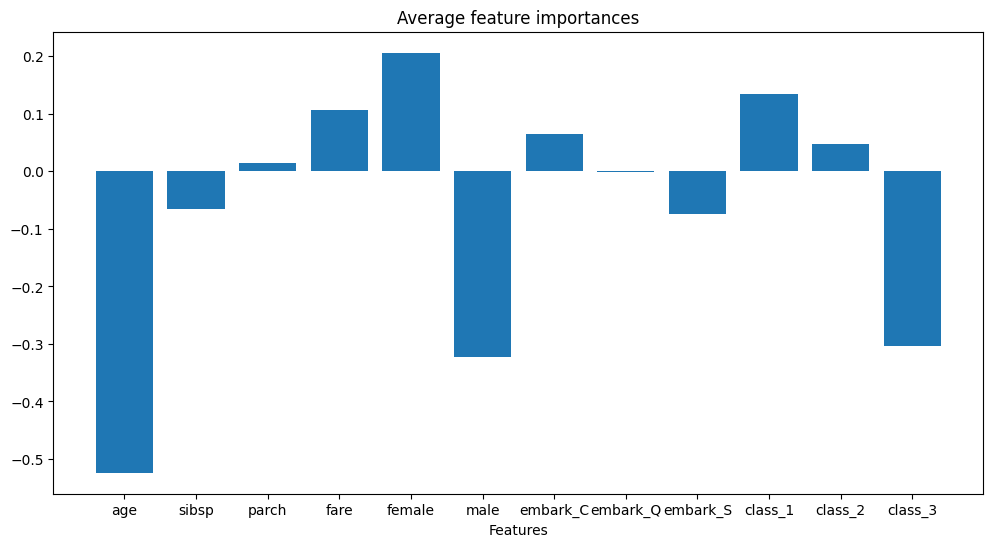

In [5]:
attr,delta=ig.attribute(test_input_tensor,target=1,return_convergence_delta=True)
attr=attr.detach().numpy()
def visualize_importances(feature_names,importances,title='Average feature importances',plot=True,axis_title='Features'):
    print(title)
    for i in range(len(feature_names)):
        print(f'{feature_names[i]}: {importances[i]:.3f}')
    x_pos=(np.arange(len(feature_names)))
    if plot:
        plt.figure(figsize=(12,6))
        plt.bar(x_pos,importances,align='center')
        plt.xticks(x_pos,feature_names,wrap=True)
        plt.xlabel(axis_title)
        plt.title(title)
visualize_importances(feature_names,np.mean(attr,axis=0))

Text(0.5, 1.0, 'Distribution of sibsp attribution values')

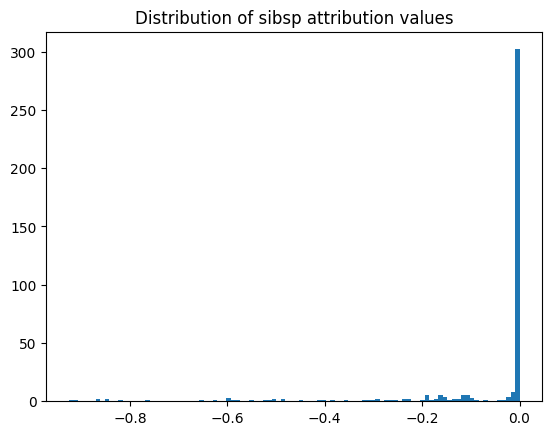

In [6]:
plt.hist(attr[:,1],100)
plt.title('Distribution of sibsp attribution values')

Text(0, 0.5, 'Average attribution')

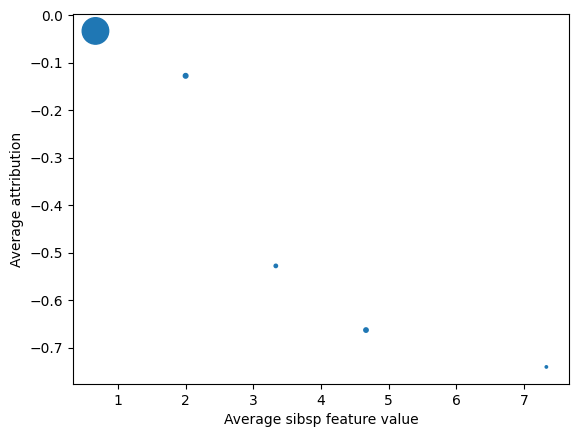

In [7]:
bin_means,bin_edges,_=stats.binned_statistic(test_features[:,1],attr[:,1],statistic='mean',bins=6)
bin_count,_,_=stats.binned_statistic(test_features[:,1],attr[:,1],statistic='count',bins=6)
bin_width=(bin_edges[1]-bin_edges[0])
bin_centers=bin_edges[1:]-bin_width/2
plt.scatter(bin_centers,bin_means,s=bin_count)
plt.xlabel('Average sibsp feature value')
plt.ylabel('Average attribution')

Average neuron importances
0: -0.005
1: -0.410
2: -0.231
3: 0.039
4: 0.029
5: 0.003
6: 0.043
7: 0.011
8: 0.006
9: 0.023
10: -0.186
11: -0.011


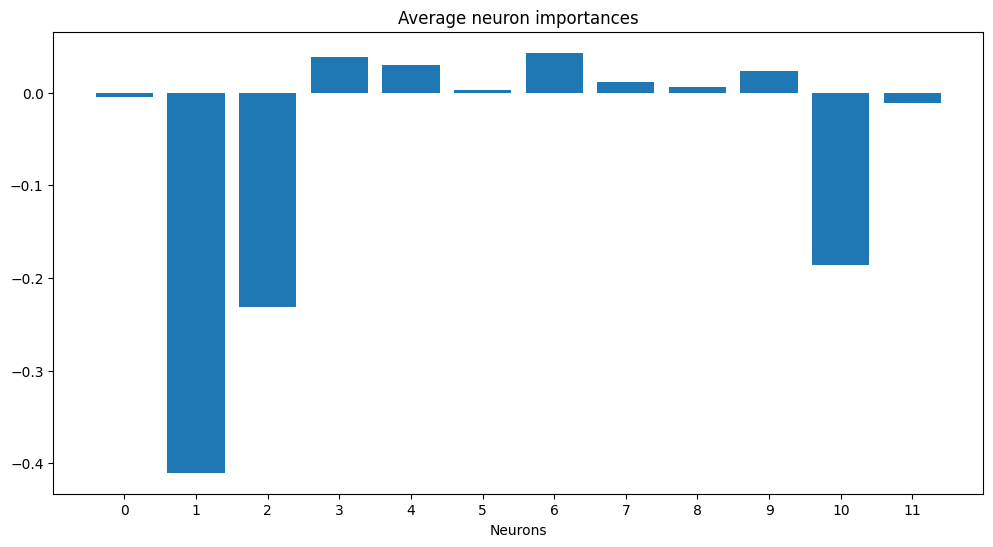

In [8]:
cond=LayerConductance(net,net.sigmoid1)
cond_vals=cond.attribute(test_input_tensor,target=1)
cond_vals=cond_vals.detach().numpy()
visualize_importances(range(12),np.mean(cond_vals,axis=0),title='Average neuron importances',axis_title='Neurons')

Text(0.5, 1.0, 'Neuron 7 distribution')

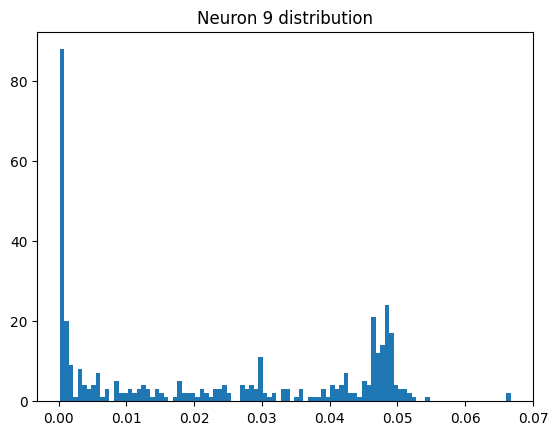

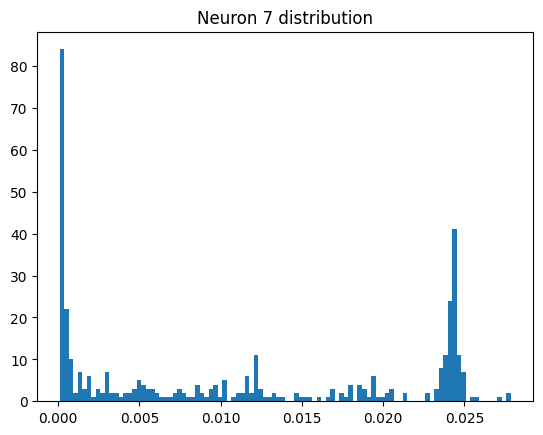

In [9]:
plt.hist(cond_vals[:,9],100)
plt.title('Neuron 9 distribution')
plt.figure()
plt.hist(cond_vals[:,7],100)
plt.title('Neuron 7 distribution')

Text(0.5, 1.0, 'Neuron 10 distribution')

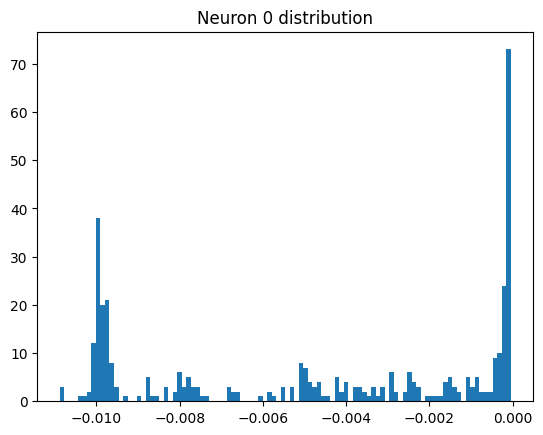

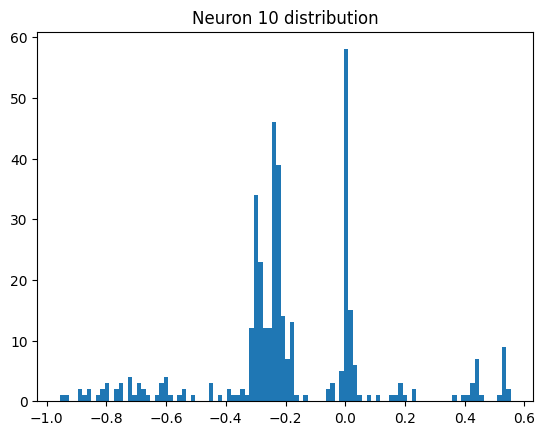

In [10]:
plt.hist(cond_vals[:,0],100)
plt.title('Neuron 0 distribution')
plt.figure()
plt.hist(cond_vals[:,10],100)
plt.title('Neuron 10 distribution')

Average feature importances for neuron 0
age: -0.004
sibsp: -0.000
parch: -0.000
fare: -0.001
female: -0.000
male: -0.000
embark_C: -0.000
embark_Q: -0.000
embark_S: -0.000
class_1: -0.000
class_2: -0.000
class_3: -0.000


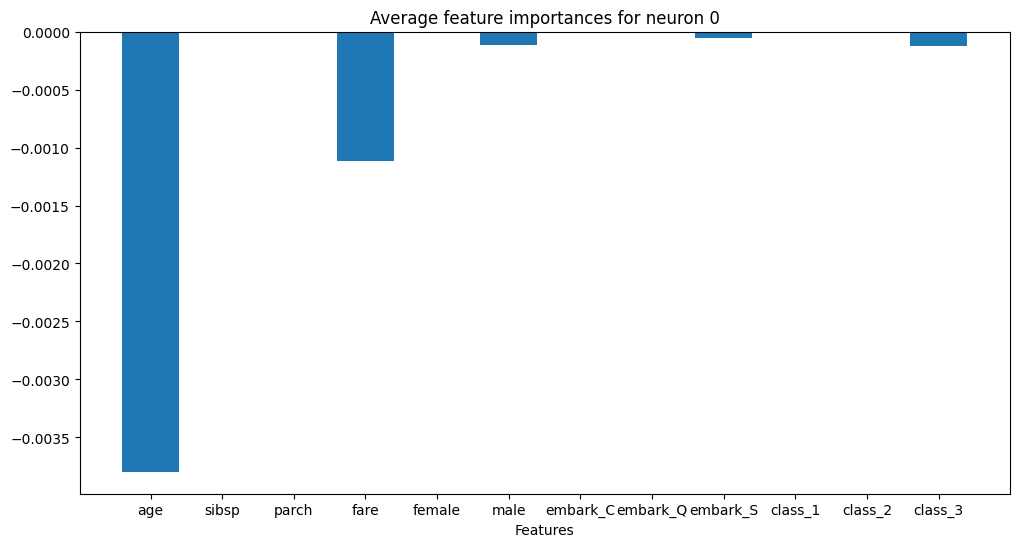

In [11]:
neuron_cond=NeuronConductance(net,net.sigmoid1)
neuron_cond_vals_10=neuron_cond.attribute(test_input_tensor,neuron_selector=10,target=1)
neuron_cond_vals_0=neuron_cond.attribute(test_input_tensor,neuron_selector=0,target=1)
visualize_importances(feature_names,neuron_cond_vals_0.mean(dim=0).detach().numpy(),title='Average feature importances for neuron 0')

Average feature importances for neuron 10
age: -0.014
sibsp: -0.016
parch: -0.012
fare: 0.003
female: 0.122
male: -0.201
embark_C: 0.008
embark_Q: 0.010
embark_S: -0.040
class_1: 0.030
class_2: 0.009
class_3: -0.078


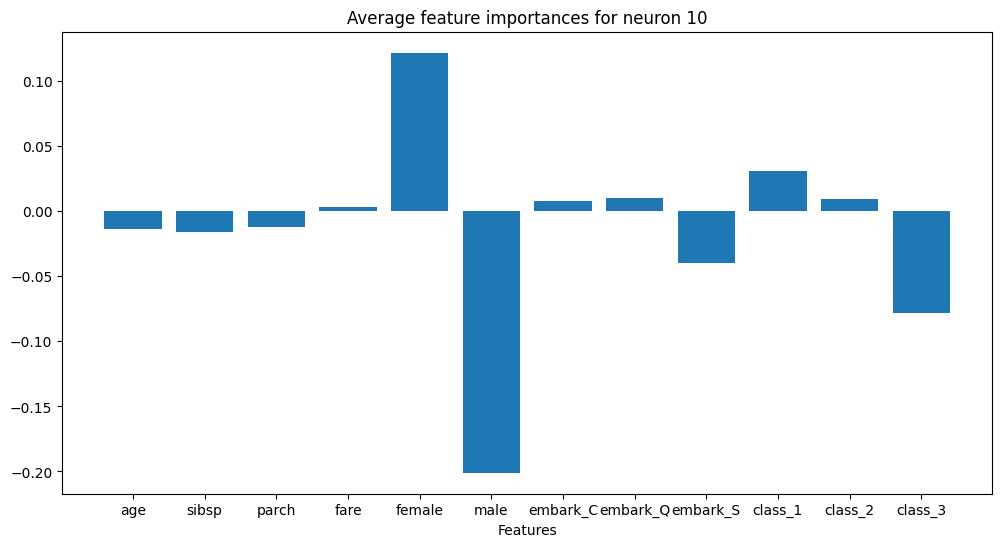

In [12]:
visualize_importances(feature_names,neuron_cond_vals_10.mean(dim=0).detach().numpy(),title='Average feature importances for neuron 10')